# Statistical foundations of Machine Learning

## INFO-F-422 TP: Ensembles of models and feature selection

Yann-Aël Le Borgne, Fabrizio Carcillo and Gianluca Bontempi

May 2, 2017

## Overview

Ensembles of models and feature selection are two machine learning techniques which can be used to improve the accuracy of preditions. 

Ensembles of models consist in building several predictive models using resampled subsets of the original training set. The method works particularly well for predictive models with high variance (for example, decision trees or neural networks). The average prediction of the resulting models usually strongly decreases the variance component of the error, and as a consequence improves the prediction accuracy. 

Feature selection aims at reducing the dimensionality of the problem, and is useful when input variables contain redundant or irrelevant (noisy) information. Benefits are twofold: it decreases the training time by simplifying the problem, and it decreases the complexity of the predictive model. This in turn usually improves the prediction accuracy, since high-dimensionality makes predictive models more prone to overfitting, and estimates of parameters more variant. 

In this session, we will illustrate both techniques using the IMDB 5000 dataset, which contains 27 variables describing 5043 movies. The variables contain information about the director, actors, number of Facebook likes for each actor, duration, genre, language, country, etc... We will use them to predict the movie success (through the IMDB score). The dataset together with a description of the variables is at https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset.

The dataset is on the github of the course, in datasets/movie_metadata.csv

## Data overview and preprocessing

Let us load and select a random subset of 1000 movies

In [1]:
data<-read.csv("datasets/movie_metadata.csv")
set.seed(2)
data<-data[sample(nrow(data),1000),]

### Dataset overview

In [2]:
dim(data)


[1] 1000   28

In [3]:
options(repr.matrix.max.cols=50)
data[1:2,]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
933,Color,James L. Brooks,156,139,274,285,Yeardley Smith,625,147637474,Comedy|Drama|Romance,Lupe Ontiveros,As Good as It Gets,224671,1474,Shirley Knight,0,dog|friendship|neighbor|unlikely friendship|writer,http://www.imdb.com/title/tt0119822/?ref_=fn_tt_tt_1,470,English,USA,PG-13,5e+07,1997,440,7.7,1.85,11000
3542,Color,Robert C. Cooper,18,97,49,687,Christopher Judge,878,NA,Action|Adventure|Drama|Fantasy|Sci-Fi,Ben Browder,Stargate: The Ark of Truth,15862,4334,Julian Sands,5,2000s|evil god|space opera|stargate|wormhole,http://www.imdb.com/title/tt0942903/?ref_=fn_tt_tt_1,42,English,USA,,NA,2008,847,7.4,1.78,389


In [4]:
summary(data)

              color              director_name num_critic_for_reviews
                 :  5                   : 20   Min.   :  1.00        
  Black and White: 46   Clint Eastwood  :  9   1st Qu.: 49.25        
 Color           :949   Sam Raimi       :  6   Median :108.50        
                        Steven Spielberg:  6   Mean   :143.49        
                        Todd Phillips   :  6   3rd Qu.:202.50        
                        Woody Allen     :  5   Max.   :813.00        
                        (Other)         :948   NA's   :10            
    duration     director_facebook_likes actor_3_facebook_likes
 Min.   : 11.0   Min.   :    0.0         Min.   :    0.0       
 1st Qu.: 93.0   1st Qu.:    6.0         1st Qu.:  123.0       
 Median :104.0   Median :   44.0         Median :  362.0       
 Mean   :107.7   Mean   :  735.7         Mean   :  618.1       
 3rd Qu.:118.0   3rd Qu.:  188.0         3rd Qu.:  637.5       
 Max.   :511.0   Max.   :22000.0         Max.   :23000.0

We see there is a mix of categorical and numerical variables, and some missing values. In order to simplify the analysis, let us remove the categorical variables, and set NA values to the variables.

### Remove categorical variables

Check the type of input variables

In [5]:
sapply(data[1,],class)

color             director_name    num_critic_for_reviews 
                 "factor"                  "factor"                 "integer" 
                 duration   director_facebook_likes    actor_3_facebook_likes 
                "integer"                 "integer"                 "integer" 
             actor_2_name    actor_1_facebook_likes                     gross 
                 "factor"                 "integer"                 "integer" 
                   genres              actor_1_name               movie_title 
                 "factor"                  "factor"                  "factor" 
          num_voted_users cast_total_facebook_likes              actor_3_name 
                "integer"                 "integer"                  "factor" 
     facenumber_in_poster             plot_keywords           movie_imdb_link 
                "integer"                  "factor"                  "factor" 
     num_user_for_reviews                  language                   country 
                "integer"                  "factor"                  "factor" 
           content_rating                    budget                title_year 
                 "factor"                 "numeric"                 "integer" 
   actor_2_facebook_likes                imdb_score              aspect_ratio 
                "integer"                 "numeric"                 "numeric" 
     movie_facebook_likes 
                "integer"

Get indices of categorical (factor) variables

In [6]:
factor_variables<-which(sapply(data[1,],class)=="factor")
factor_variables

color   director_name    actor_2_name          genres    actor_1_name 
              1               2               7              10              11 
    movie_title    actor_3_name   plot_keywords movie_imdb_link        language 
             12              15              17              18              20 
        country  content_rating 
             21              22

Remove categorical variables

In [7]:
data_preprocessed<-data[,-factor_variables]
summary(data_preprocessed)

 num_critic_for_reviews    duration     director_facebook_likes
 Min.   :  1.00         Min.   : 11.0   Min.   :    0.0        
 1st Qu.: 49.25         1st Qu.: 93.0   1st Qu.:    6.0        
 Median :108.50         Median :104.0   Median :   44.0        
 Mean   :143.49         Mean   :107.7   Mean   :  735.7        
 3rd Qu.:202.50         3rd Qu.:118.0   3rd Qu.:  188.0        
 Max.   :813.00         Max.   :511.0   Max.   :22000.0        
 NA's   :10             NA's   :2       NA's   :20             
 actor_3_facebook_likes actor_1_facebook_likes     gross          
 Min.   :    0.0        Min.   :     0.0       Min.   :     1332  
 1st Qu.:  123.0        1st Qu.:   591.2       1st Qu.:  5895238  
 Median :  362.0        Median :   983.0       Median : 28031250  
 Mean   :  618.1        Mean   :  6594.5       Mean   : 52916026  
 3rd Qu.:  637.5        3rd Qu.: 11000.0       3rd Qu.: 64933670  
 Max.   :23000.0        Max.   :260000.0       Max.   :533316061  
 NA's   :5         

### Replace NA values with mean values

In [8]:
replace_na_with_mean_value<-function(vec) {
    mean_vec<-mean(vec,na.rm=T)
    vec[is.na(vec)]<-mean_vec
    vec
}

In [9]:
data_preprocessed<-data.frame(apply(data_preprocessed,2,replace_na_with_mean_value))
summary(data_preprocessed)

 num_critic_for_reviews    duration     director_facebook_likes
 Min.   :  1.0          Min.   : 11.0   Min.   :    0.0        
 1st Qu.: 50.0          1st Qu.: 93.0   1st Qu.:    7.0        
 Median :110.0          Median :104.0   Median :   47.5        
 Mean   :143.5          Mean   :107.7   Mean   :  735.7        
 3rd Qu.:199.0          3rd Qu.:118.0   3rd Qu.:  210.5        
 Max.   :813.0          Max.   :511.0   Max.   :22000.0        
 actor_3_facebook_likes actor_1_facebook_likes     gross          
 Min.   :    0.0        Min.   :     0.0       Min.   :     1332  
 1st Qu.:  123.8        1st Qu.:   591.8       1st Qu.:  9709388  
 Median :  366.0        Median :   984.5       Median : 39670256  
 Mean   :  618.1        Mean   :  6594.5       Mean   : 52916026  
 3rd Qu.:  635.5        3rd Qu.: 11000.0       3rd Qu.: 54422773  
 Max.   :23000.0        Max.   :260000.0       Max.   :533316061  
 num_voted_users   cast_total_facebook_likes facenumber_in_poster
 Min.   :     13 

### Input and output variables

The output variable (Y) is the `imdb_score`, and all other variables (X) are considered as inputs.

In [10]:
set.seed(3)

X<-data_preprocessed[,setdiff(colnames(data_preprocessed),"imdb_score")]
Y<-data_preprocessed[,"imdb_score"]

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables


Distribution of the `imdb_score`

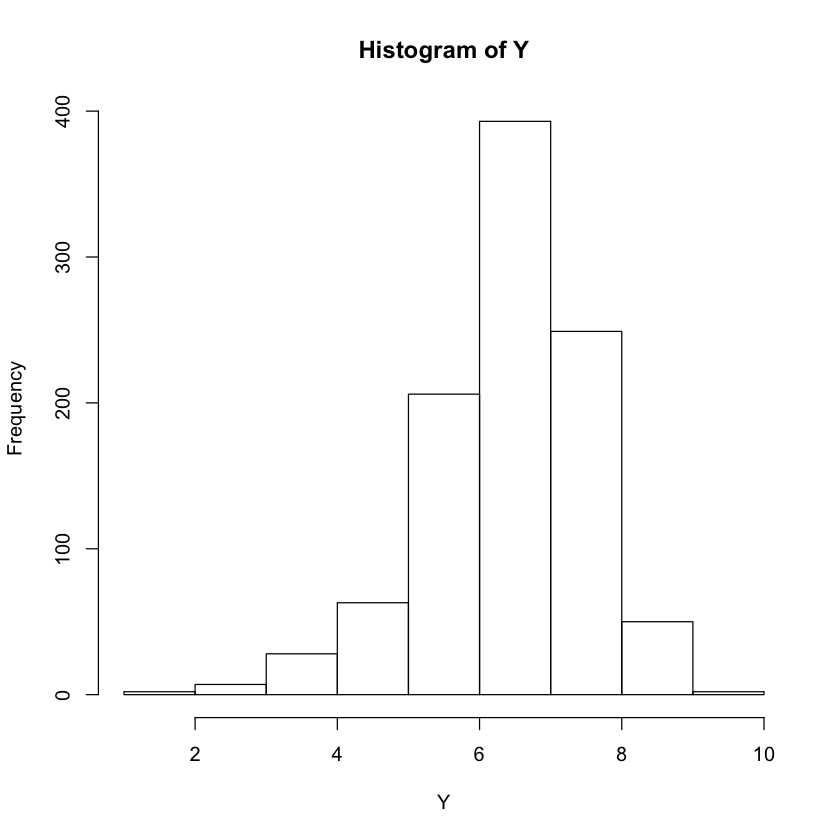

In [11]:
hist(Y)

In [12]:
mean(Y)

[1] 6.4543

In [13]:
var(Y)

[1] 1.267369

### 1) Modelling with linear and decision tree models

#### Linear model

* Let us create a linear model for predicting the IMDB score on the basis of the other variables, and compute its empricial mean square error

In [14]:
DS<-cbind(X,imdb_score=Y)
    
model<- lm(imdb_score~.,DS) ### Fill with your code here
        
Y.hat<- predict(model,X)
        
empirical_error<-mean((Y.hat-Y)^2) ### Fill with your code here

print(paste("Empirical error=",round(empirical_error,digits=4)))



[1] "Empirical error= 0.8696"


* Which input variables are statistically correlated with the output?

In [15]:
summary(model)


Call:
lm(formula = imdb_score ~ ., data = DS)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3647 -0.4775  0.0631  0.5847  3.5134 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                4.973e+01  5.479e+00   9.077  < 2e-16 ***
num_critic_for_reviews     2.807e-03  4.120e-04   6.814 1.65e-11 ***
duration                   3.270e-03  1.225e-03   2.669  0.00772 ** 
director_facebook_likes    9.857e-06  1.093e-05   0.902  0.36727    
actor_3_facebook_likes     3.486e-05  4.959e-05   0.703  0.48229    
actor_1_facebook_likes     5.120e-05  2.584e-05   1.981  0.04782 *  
gross                     -7.961e-10  6.694e-10  -1.189  0.23464    
num_voted_users            3.453e-06  3.730e-07   9.256  < 2e-16 ***
cast_total_facebook_likes -5.180e-05  2.558e-05  -2.025  0.04312 *  
facenumber_in_poster      -9.942e-03  1.300e-02  -0.765  0.44472    
num_user_for_reviews      -5.356e-04  1.359e-04  -3.942 8.66e-05 ***
budget          

* Compute the validation error with a 10-fold cross-validation

In [16]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### Complete the code. i.ts should be the indices of the tessefor the i-th fold
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]  
     
     i.tr<-setdiff(1:N,i.ts)                ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]                          
     
     DS<-cbind(X.tr,imdb_score=Y.tr)
    
     model<- lm(imdb_score~.,DS)
        
     Y.hat.ts<- predict(model,X.ts)
        
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
}
    

print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))



[1] "CV error= 0.9138  ; std dev= 0.1508"


#### Decision tree

* Modify the previous code to compute the empirical error using a decision tree model. Use the rpart package (see `?rpart` for help)

In [17]:
library(rpart)       ### Run install.packages("rpart") to install

In [18]:
DS<-cbind(X,imdb_score=Y)

model<- rpart(imdb_score~.,DS) ### Fill with you code here
        
Y.hat<- predict(model,X)
        
empirical_error<-mean((Y.hat-Y)^2) 

print(paste("Empirical error=",round(empirical_error,digits=4)))



[1] "Empirical error= 0.6889"


* Plot the resulting tree using the `prp` function from the library `rpart.plot`

In [19]:
library(rpart.plot)  ### Run install.packages("rpart.plot") to install

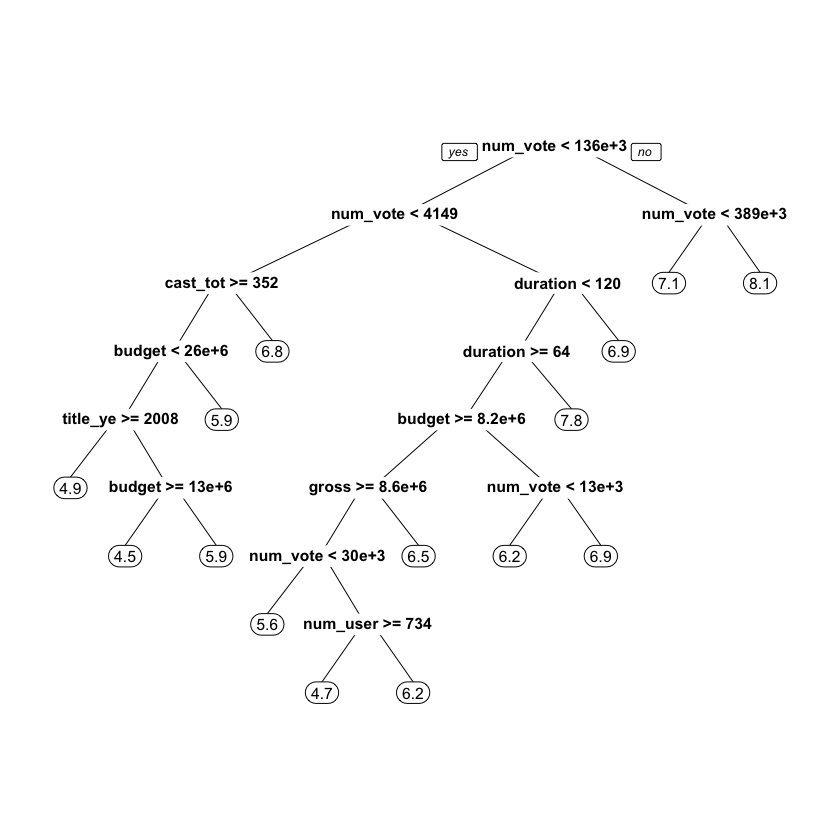

In [20]:
prp(model)

* What is the 10-fold cross-validation error using a decision tree model?

In [21]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]  
     
     i.tr<-setdiff(1:N,i.ts)                
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]                          
     
     DS<-cbind(X.tr,imdb_score=Y.tr)
    
     model<- rpart(imdb_score~.,DS)
        
     Y.hat.ts<- predict(model,X.ts)
        
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
    }
    

print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))



[1] "CV error= 0.8718  ; std dev= 0.1016"


## 2) Ensemble of models

Let us know create an ensemble of R linear models to make predictions. Complete the code below so that

* The training set is resampled before building a model
* The predictions of all model are averaged before testing

In [22]:
size.CV<-floor(N/10)
R<-20

CV.err<-numeric(10)

for (i in 1:10) {
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]  
     
     
     i.tr<-setdiff(1:N,i.ts)                
    
     Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol=R)
    
     for (r in 1:R) {
         i.tr.resample<-sample(i.tr,rep=T)
         X.tr<-X[i.tr.resample,]
         Y.tr<-Y[i.tr.resample]                          
     
         DS<-cbind(X.tr,imdb_score=Y.tr)
    
         model<- lm(imdb_score~.,DS)
        
         Y.hat.ts.R[,r]<- predict(model,X.ts)
     
     }
    
     Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
     }

print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))


[1] "CV error= 0.9127  ; std dev= 0.1528"


* Is the CV error lower than with a single linear model?
* Use a decision tree as the base model. Is the CV error lower?

## 3) Feature selection

Two are the main approaches to feature selection:


* **Filter methods:** they are preprocessing methods. They attempt to
assess the merits of features from the data, ignoring the effects of
the selected feature subset on the performance of the learning
algorithm. Examples are methods that select variables by ranking them
through compression techniques (like PCA), or by computing correlation or a more advanced similarity measure such as minimum redundancy maximum relevance (mRMR) with the output.

*  **Wrapper methods:** these methods assess subsets of variables
according to their usefulness to a given predictor. The method
conducts a search for a good subset using the learning algorithm
itself as part of the evaluation function. The problem boils 
down to a problem of stochastic state space search. Example
are the stepwise methods proposed in linear regression analysis.



### Filter methods

#### Correlation with the output

* The following code performs features selection by keeping the most correlated variables with the output. Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?


In [23]:
size.CV<-floor(N/10)

CV.err<-matrix(0,nrow=n,ncol=10)

for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
     
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
     
    correlation<-abs(cor(X.tr,Y.tr))
    ranking<-sort(correlation,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],imdb_score=Y.tr)
        model<- lm(imdb_score~.,DS)
        
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])
        
        CV.err[nb_features,i]<-mean((Y.hat.ts-Y.ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))



 [1] "#Features:  1  ; CV error= 1.0018  ; std dev= 0.0678" 
 [2] "#Features:  2  ; CV error= 0.9915  ; std dev= 0.0706" 
 [3] "#Features:  3  ; CV error= 0.9824  ; std dev= 0.0852" 
 [4] "#Features:  4  ; CV error= 0.9812  ; std dev= 0.0804" 
 [5] "#Features:  5  ; CV error= 0.9828  ; std dev= 0.0972" 
 [6] "#Features:  6  ; CV error= 0.968  ; std dev= 0.0912"  
 [7] "#Features:  7  ; CV error= 0.9181  ; std dev= 0.1027" 
 [8] "#Features:  8  ; CV error= 0.9088  ; std dev= 0.1126" 
 [9] "#Features:  9  ; CV error= 0.9098  ; std dev= 0.114"  
[10] "#Features:  10  ; CV error= 0.9081  ; std dev= 0.1213"
[11] "#Features:  11  ; CV error= 0.9111  ; std dev= 0.1198"
[12] "#Features:  12  ; CV error= 0.9098  ; std dev= 0.1211"
[13] "#Features:  13  ; CV error= 0.9141  ; std dev= 0.1413"
[14] "#Features:  14  ; CV error= 0.9243  ; std dev= 0.145" 
[15] "#Features:  15  ; CV error= 0.9138  ; std dev= 0.1508"


#### PCA

* The following code performs features selection by first transforming the inputs using PCA, and then keeping the most relevant principal components in the model. Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?



In [24]:
size.CV<-floor(N/10)

CV.err<-matrix(0,nrow=n,ncol=10)

X_pca<-data.frame(prcomp(X,retx=T)$x)

for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X_pca[i.ts,]  
    Y.ts<-Y[i.ts]  
     
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X_pca[i.tr,]
    Y.tr<-Y[i.tr]
     
    for (nb_features in 1:n) {
        DS<-cbind(X.tr[,1:nb_features,drop=F],imdb_score=Y.tr)
        model<- lm(imdb_score~.,DS)
        
        Y.hat.ts<- predict(model,X.ts[,1:nb_features,drop=F])
        
        CV.err[nb_features,i]<-mean((Y.hat.ts-Y.ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))


 [1] "#Features:  1  ; CV error= 1.2051  ; std dev= 0.1211" 
 [2] "#Features:  2  ; CV error= 1.199  ; std dev= 0.1282"  
 [3] "#Features:  3  ; CV error= 0.9963  ; std dev= 0.081"  
 [4] "#Features:  4  ; CV error= 1.0043  ; std dev= 0.0777" 
 [5] "#Features:  5  ; CV error= 1.0046  ; std dev= 0.0815" 
 [6] "#Features:  6  ; CV error= 1.0084  ; std dev= 0.0818" 
 [7] "#Features:  7  ; CV error= 1.0063  ; std dev= 0.0753" 
 [8] "#Features:  8  ; CV error= 0.9993  ; std dev= 0.0871" 
 [9] "#Features:  9  ; CV error= 1.002  ; std dev= 0.0925"  
[10] "#Features:  10  ; CV error= 1.0025  ; std dev= 0.095" 
[11] "#Features:  11  ; CV error= 0.9773  ; std dev= 0.1005"
[12] "#Features:  12  ; CV error= 0.9661  ; std dev= 0.1263"
[13] "#Features:  13  ; CV error= 0.9142  ; std dev= 0.1412"
[14] "#Features:  14  ; CV error= 0.9157  ; std dev= 0.1426"
[15] "#Features:  15  ; CV error= 0.9138  ; std dev= 0.1508"


### Wrapper method: Forward selection

* The following code performs features selection by using a forward selection method (See slide 20 in http://uv.ulb.ac.be/pluginfile.php/874401/mod_resource/content/1/fsel.pdf). Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?


In [25]:
size.CV<-floor(N/10)

selected<-NULL

for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV.err<-matrix(0,nrow=length(candidates),ncol=10)
    
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        for (i in 1:10) {
            i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
            X.ts<-X[i.ts,features_to_include,drop=F]  
            Y.ts<-Y[i.ts]  
     
            i.tr<-setdiff(1:N,i.ts)
            X.tr<-X[i.tr,features_to_include,drop=F]
            Y.tr<-Y[i.tr]
     
            DS<-cbind(X.tr,imdb_score=Y.tr)
            model<- lm(imdb_score~.,DS)
        
            Y.hat.ts<- predict(model,X.ts)
        
            CV.err[j,i]<-mean((Y.hat.ts-Y.ts)^2)
        }
    }
    CV.err.mean<-apply(CV.err,1,mean)
    CV.err.sd<-apply(CV.err,1,sd)
    selected_current<-which.min(CV.err.mean)              
    selected<-c(selected,candidates[selected_current])
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV.err.mean[selected_current],digits=4), " ; std dev=",round(CV.err.sd[selected_current],digits=4)))

}
                   


[1] "Round  1  ; Selected feature:  7  ; CV error= 1.0018  ; std dev= 0.0678"
[1] "Round  2  ; Selected feature:  12  ; CV error= 0.9618  ; std dev= 0.081"
[1] "Round  3  ; Selected feature:  1  ; CV error= 0.9261  ; std dev= 0.0961"
[1] "Round  4  ; Selected feature:  10  ; CV error= 0.912  ; std dev= 0.1088"
[1] "Round  5  ; Selected feature:  11  ; CV error= 0.9062  ; std dev= 0.1085"
[1] "Round  6  ; Selected feature:  2  ; CV error= 0.9016  ; std dev= 0.1243"
[1] "Round  7  ; Selected feature:  14  ; CV error= 0.9004  ; std dev= 0.1337"
[1] "Round  8  ; Selected feature:  4  ; CV error= 0.9  ; std dev= 0.1361"
[1] "Round  9  ; Selected feature:  13  ; CV error= 0.8989  ; std dev= 0.1372"
[1] "Round  10  ; Selected feature:  6  ; CV error= 0.899  ; std dev= 0.1342"
[1] "Round  11  ; Selected feature:  3  ; CV error= 0.8992  ; std dev= 0.1333"
[1] "Round  12  ; Selected feature:  15  ; CV error= 0.8996  ; std dev= 0.1336"
[1] "Round  13  ; Selected feature:  9  ; CV error= 0.9017  ;

## Further preprocessing to add categorical variables

Categorical variables usually need to be transformed with 'one-hot-encoding' in order to be processed by a learning algorithm. That is, for each value of the categorical variable, a binary feature is created, which is set to one whenever that value is present. This can be done using the `dummy.data.frame` of the `dummies` package.

```
install.packages('dummies')
library(dummies)
```

In the following, we add some categorical variables to the peprocessing dataset. The set of categorical variables is

In [26]:
library(dummies)

dummies-1.5.6 provided by Decision Patterns



In [27]:
factor_variables

color   director_name    actor_2_name          genres    actor_1_name 
              1               2               7              10              11 
    movie_title    actor_3_name   plot_keywords movie_imdb_link        language 
             12              15              17              18              20 
        country  content_rating 
             21              22

Let us have an overview of the their content

In [28]:
data_factor<-data[,factor_variables]

In [29]:
dim(data_factor)

[1] 1000   12

In [30]:
data_factor[1:2,]

,color,director_name,actor_2_name,genres,actor_1_name,movie_title,actor_3_name,plot_keywords,movie_imdb_link,language,country,content_rating
933,Color,James L. Brooks,Yeardley Smith,Comedy|Drama|Romance,Lupe Ontiveros,As Good as It Gets,Shirley Knight,dog|friendship|neighbor|unlikely friendship|writer,http://www.imdb.com/title/tt0119822/?ref_=fn_tt_tt_1,English,USA,PG-13
3542,Color,Robert C. Cooper,Christopher Judge,Action|Adventure|Drama|Fantasy|Sci-Fi,Ben Browder,Stargate: The Ark of Truth,Julian Sands,2000s|evil god|space opera|stargate|wormhole,http://www.imdb.com/title/tt0942903/?ref_=fn_tt_tt_1,English,USA,


Let us keep four of them: Color, language, country and content_rating, and transform them with one-hot-encoding

In [31]:
variable_to_keep<-c("color","language","country","content_rating")

In [32]:
data_factor_onehot <- dummy.data.frame(data_factor[,variable_to_keep], sep="_")

In [33]:
dim(data_factor_onehot)

[1] 1000   76

In [34]:
data_factor_onehot[1:2,]

,color_,color_ Black and White,color_Color,language_,language_Aboriginal,language_Arabic,language_Bosnian,language_Cantonese,language_Dutch,language_English,language_French,language_German,language_Hebrew,language_Hindi,language_Icelandic,language_Italian,language_Japanese,language_Mandarin,language_Mongolian,language_Persian,language_Polish,language_Portuguese,language_Spanish,language_Swahili,language_Swedish,⋯,country_Peru,country_Poland,country_Russia,country_South Korea,country_Spain,country_Sweden,country_UK,country_USA,country_United Arab Emirates,content_rating_,content_rating_Approved,content_rating_G,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-MA,content_rating_TV-PG,content_rating_Unrated,content_rating_X
933,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3542,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


These could be added to the previously preprocessed dataset, and used to further improve the prediction accuracy using the feature selection/ensemble techniques seen above. 

In [35]:
data_preprocessed_extended<-cbind(data_preprocessed,data_factor_onehot)

In [36]:
dim(data_preprocessed_extended)

[1] 1000   92

In [37]:
summary(data_preprocessed_extended)

 num_critic_for_reviews    duration     director_facebook_likes
 Min.   :  1.0          Min.   : 11.0   Min.   :    0.0        
 1st Qu.: 50.0          1st Qu.: 93.0   1st Qu.:    7.0        
 Median :110.0          Median :104.0   Median :   47.5        
 Mean   :143.5          Mean   :107.7   Mean   :  735.7        
 3rd Qu.:199.0          3rd Qu.:118.0   3rd Qu.:  210.5        
 Max.   :813.0          Max.   :511.0   Max.   :22000.0        
 actor_3_facebook_likes actor_1_facebook_likes     gross          
 Min.   :    0.0        Min.   :     0.0       Min.   :     1332  
 1st Qu.:  123.8        1st Qu.:   591.8       1st Qu.:  9709388  
 Median :  366.0        Median :   984.5       Median : 39670256  
 Mean   :  618.1        Mean   :  6594.5       Mean   : 52916026  
 3rd Qu.:  635.5        3rd Qu.: 11000.0       3rd Qu.: 54422773  
 Max.   :23000.0        Max.   :260000.0       Max.   :533316061  
 num_voted_users   cast_total_facebook_likes facenumber_in_poster
 Min.   :     13 

## Using other predictive models

Other models could be used, for example support vector machines, neural networks, K-nearest neighbors (using the `svm`, `nnt`or `lazy` functions from the `e1071`, `nnet` or `lazy` packages, respectively). Note that scaling the data is usually necessary when using neural networks and K-nearest neighbors approaches. 